# Practice for Image Processing Logic
Using references from previous data wrangling labs and inclass1 to develop our functions for image processing.

In [12]:
#imports
#importing os to deal with file system
import os

#imports for data wrangling
import numpy as np
import pandas as pd

#imports to allow us to work with our images in matplot lib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#importing open CV
try:
    import cv2
except:
    !pip install opencv-python
    import cv2

#import Pillow
try:
    from PIL import Image, ImageFilter
except:
    !pip install opencv-python
    from PIL import Image, ImageFilter


# Thresholding
Following the guide from InClass1, 


in_image (720, 1280, 3) uint8 0 255


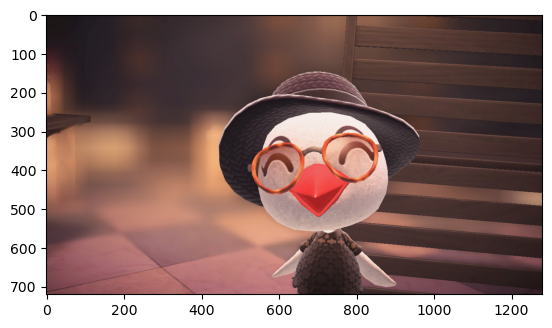

In [13]:
#input image
in_img = cv2.imread("test1.png")

in_img = in_img[:,:,::-1]
print('in_image', in_img.shape, in_img.dtype, in_img.min(), in_img.max())

plt.figure()
plt.imshow(in_img)


grayscaleImg [[21 21 21 ... 34 34 34]
 [21 21 21 ... 34 34 35]
 [21 21 21 ... 34 34 34]
 ...
 [71 71 72 ... 35 35 35]
 [74 75 75 ... 36 36 36]
 [74 75 76 ... 36 36 36]] (720, 1280) uint8 6 251


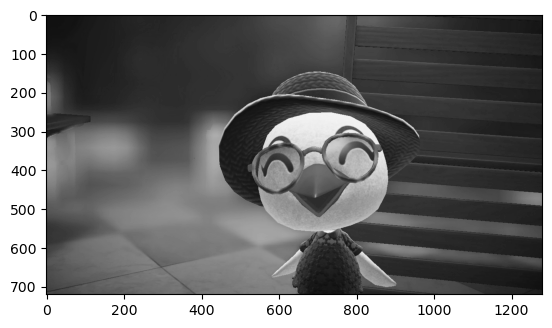

In [14]:
#converting our original test image into a grayscale image
grayImg = cv2.cvtColor(in_img, cv2.COLOR_BGR2GRAY)
#display our grayscale image
print('grayscaleImg', grayImg, grayImg.shape, grayImg.dtype, grayImg.min(), grayImg.max())

plt.figure()
plt.imshow(grayImg, cmap='gray')

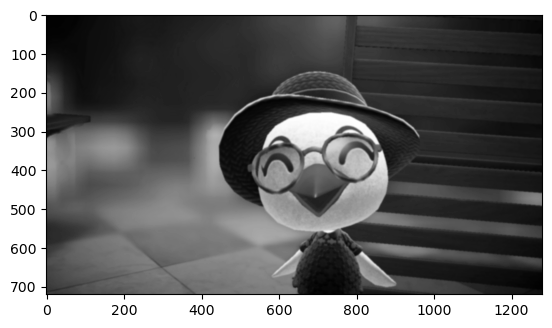

In [15]:
#blurring
blurImg = cv2.GaussianBlur(grayImg, (7,7), 0)

plt.figure()
plt.imshow(blurImg, cmap='gray')


## Binary Thresholding
Testing a hardcoded binary value as we did in inclass1

Binary Thresholding (720, 1280) bool False True


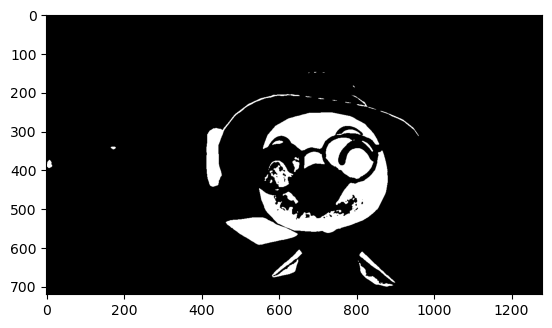

In [16]:
#applying binary thresholding
binaryImg = blurImg > 150

print('Binary Thresholding', binaryImg.shape, binaryImg.dtype, binaryImg.min(), binaryImg.max())
plt.figure()
plt.imshow(binaryImg.astype(float), cmap='gray')

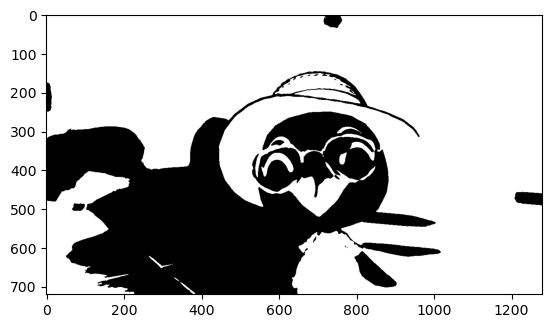

In [17]:
#Trying out inverse binary thresh from opencv
(T, binaryInv) = cv2.threshold(blurImg, 100, 255, cv2.THRESH_BINARY_INV)
plt.figure()
plt.imshow(binaryInv.astype(float), cmap='gray')

## Otsu Thresholding


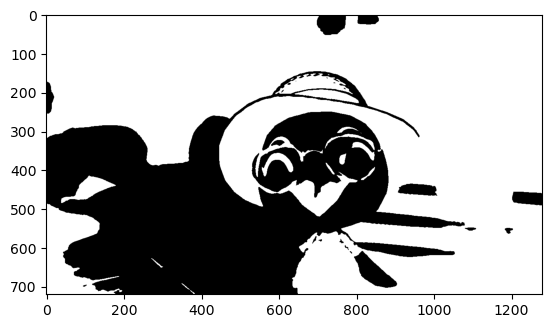

In [18]:
(T, OtsuImg) = cv2.threshold(blurImg, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

plt.figure()
plt.imshow(OtsuImg.astype(float), cmap='gray')

## Adaptive Thresholding Testing
1. Testing using mean method
2. Testing using adaptive gaussian
    - This uses the gaussian average

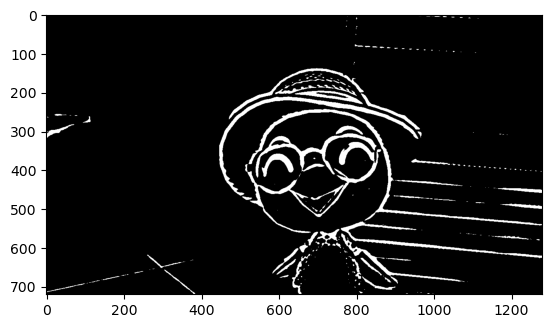

In [19]:
thresh_mean = cv2.adaptiveThreshold(blurImg, 255, 
    cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)

plt.figure()
plt.imshow(thresh_mean.astype(float), cmap='gray')

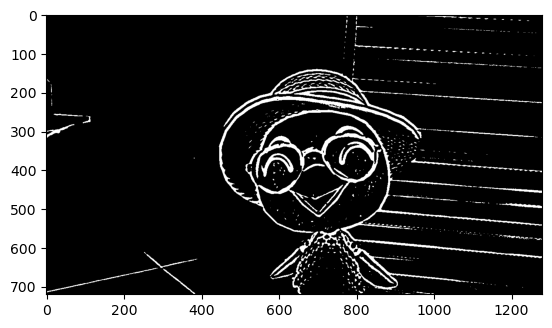

In [20]:
thresh_gaussian = cv2.adaptiveThreshold(blurImg, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 5)

plt.figure()
plt.imshow(thresh_gaussian.astype(float), cmap='gray')

# Canny Edge Detection - Using OpenCV


Documentation: 
OpenCV - Canny Edge Detection Documentation:
- https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html


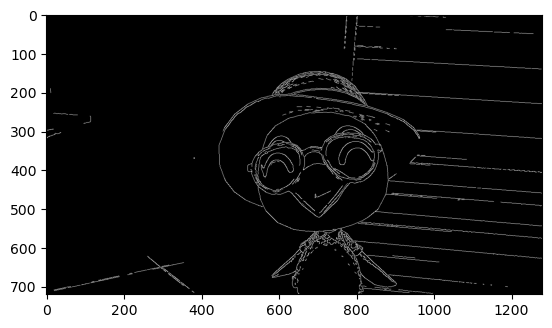

In [21]:
# grayImg is the img variable we will use here
edges = cv2.Canny(grayImg,100,150)

plt.figure()
plt.imshow(edges.astype(float), cmap='gray')
# one issue here, is that in order for us to have as dynamic of 
# an image processing process, canny would likely not be our best bet
# unless we implemented track bars to dynamically change thresholds as we process imgaes

# Contour Extraction - A Different Method 
The usual steps in contouring:
1. Grayscale conversion
2. Binarization - via thresholding or Canny Edge Detection
3. Contour Detection - via OpenCV findContours() method
4. Draw Contours
## Different Approx. Methods
1. CHAIN_APPROX_NONE -- this stores all the points along a line, this will be what we are using due to the purpose of our project. This will provide us the accurate line to trace, however it will be inefficient.
2. CHAIN_APPROX_SIMPLE -- this stores only the end points of each line

## Experimenting with Different Retrieval Modes
1. RETR_LIST -- Retrieve all the contours without establishing a parent-child relationship
2. RETR_EXTERNAL -- Returns only the extreme outer contours, which will omit the child contours
3. RETR_CCOMP -- Organizes contours into a 2-lvl hierarchy, differentiating between external and internal contours
4. RETR_TREE -- Retrieve all contours and create a full family hierarchy list

Moving forward, in order to experiment with these modes to decide the best one for the purposes of our project we are going to use our adaptive thresholding using the mean.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


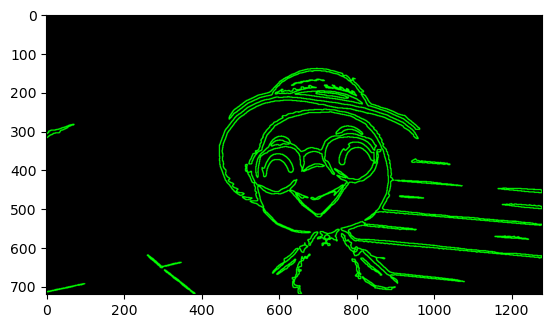

In [22]:
#we are going to use our adaptive thresh_mean results moving forward
#i feel as if adaptive thresholding using the mean is going to be the best way for us to move forward
coord_retr_list = []
# find our contours in our thresholded image
contours, hierarchy = cv2.findContours(thresh_mean, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

#Extract the coordinates of the white regions of our image
white_regions_coordinates = []
for contour in contours:
    coordinates = contour.squeeze().astype(float).tolist()
    white_regions_coordinates.append(coordinates)

# Print the coordinates of each white region
for i, region in enumerate(white_regions_coordinates):
    if type(region[0]) is list:
        if len(region) > 2:
            # Calculate the area of the contour
            area = cv2.contourArea(np.around(np.array([[pnt] for pnt in region])).astype(np.int32))
            if area > 100:
                # Convert coordinates to the required format
                crdnts = [{'x': i[0], 'y': i[1]} for i in region]
                coord_retr_list.append(crdnts)

#height and width of our image
h, w = thresh_mean.shape[:2]
#creating a black image for each
blackImg = np.zeros((h,w,3), dtype=np.uint8)

#drawing our polygons on the black image
for coords in coord_retr_list:
    ply_list = [[pnt['x'], pnt['y']] for pnt in coords]
    #defining the vertices of ply
    vertices = np.array(ply_list, dtype=np.int32)
    #drawing the polygon on the black background
    #in regards to the color portion, for the purpose of following the tut, we are using green
    # we could do something fun to to randomize colors, but we dont need to worry about that atm
    cv2.polylines(blackImg, [vertices], isClosed=True, color=(0, 255, 0), thickness=2)

plt.figure()
plt.imshow(blackImg.astype(float))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


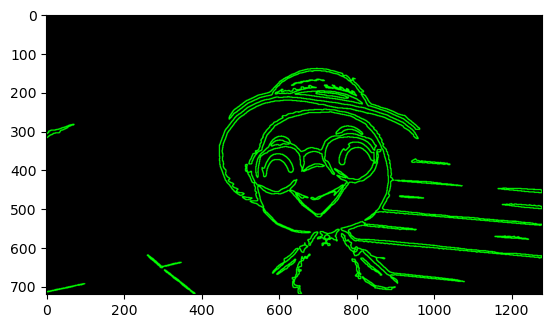

In [25]:
#we are going to use our adaptive thresh_mean results moving forward
#i feel as if adaptive thresholding using the mean is going to be the best way for us to move forward
#trying the next mode
coord_retr_ccomp = []
# find our contours in our thresholded image
contours, hierarchy = cv2.findContours(thresh_mean, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

#Extract the coordinates of the white regions of our image
white_regions_coordinates = []
for contour in contours:
    coordinates = contour.squeeze().astype(float).tolist()
    white_regions_coordinates.append(coordinates)

# Print the coordinates of each white region
for i, region in enumerate(white_regions_coordinates):
    if type(region[0]) is list:
        if len(region) > 2:
            # Calculate the area of the contour
            area = cv2.contourArea(np.around(np.array([[pnt] for pnt in region])).astype(np.int32))
            if area > 100:
                # Convert coordinates to the required format
                crdnts = [{'x': i[0], 'y': i[1]} for i in region]
                coord_retr_ccomp.append(crdnts)

#height and width of our image
h, w = thresh_mean.shape[:2]
#creating a black image for each
blackImg = np.zeros((h,w,3), dtype=np.uint8)

#drawing our polygons on the black image
for coords in coord_retr_ccomp:
    ply_list = [[pnt['x'], pnt['y']] for pnt in coords]
    #defining the vertices of ply
    vertices = np.array(ply_list, dtype=np.int32)
    #drawing the polygon on the black background
    #in regards to the color portion, for the purpose of following the tut, we are using green
    # we could do something fun to to randomize colors, but we dont need to worry about that atm
    cv2.polylines(blackImg, [vertices], isClosed=True, color=(0, 255, 0), thickness=2)

plt.figure()
plt.imshow(blackImg.astype(float))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


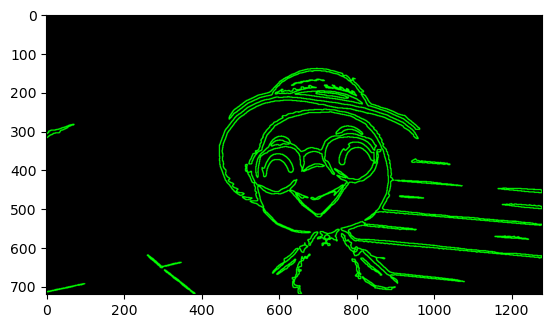

In [28]:
#we are going to use our adaptive thresh_mean results moving forward
#i feel as if adaptive thresholding using the mean is going to be the best way for us to move forward
coord_retr_tree = []
# find our contours in our thresholded image
contours, hierarchy = cv2.findContours(thresh_mean, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

#Extract the coordinates of the white regions of our image
white_regions_coordinates = []
for contour in contours:
    coordinates = contour.squeeze().astype(float).tolist()
    white_regions_coordinates.append(coordinates)

# Print the coordinates of each white region
for i, region in enumerate(white_regions_coordinates):
    if type(region[0]) is list:
        if len(region) > 2:
            # Calculate the area of the contour
            area = cv2.contourArea(np.around(np.array([[pnt] for pnt in region])).astype(np.int32))
            if area > 100:
                # Convert coordinates to the required format
                crdnts = [{'x': i[0], 'y': i[1]} for i in region]
                coord_retr_tree.append(crdnts)

#height and width of our image
h, w = thresh_mean.shape[:2]
#creating a black image for each
blackImg = np.zeros((h,w,3), dtype=np.uint8)

#drawing our polygons on the black image
for coords in coord_retr_tree:
    ply_list = [[pnt['x'], pnt['y']] for pnt in coords]
    #defining the vertices of ply
    vertices = np.array(ply_list, dtype=np.int32)
    #drawing the polygon on the black background
    #in regards to the color portion, for the purpose of following the tut, we are using green
    # we could do something fun to to randomize colors, but we dont need to worry about that atm
    cv2.polylines(blackImg, [vertices], isClosed=True, color=(0, 255, 0), thickness=2)

plt.figure()
plt.imshow(blackImg.astype(float))

# References:
- https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
- https://medium.com/@abhisheksriram845/canny-edge-detection-explained-and-compared-with-opencv-in-python-57a161b4bd19
- https://medium.com/thedeephub/contour-detection-using-opencv-detecting-and-counting-coins-2d5192597e3c
- https://medium.com/thedeephub/mastering-contouring-in-opencv-a-comprehensive-guide-10e6fe2a069a
- https://pyimagesearch.com/2021/05/12/adaptive-thresholding-with-opencv-cv2-adaptivethreshold/
- https://learnopencv.com/otsu-thresholding-with-opencv/

